#Nhiệm vụ build 1 mô hình dự đoán loài chim qua ảnh, có tổng cộng 525 loài. Mỗi ảnh chỉ chưa 1 loài chim duy nhất. Sử dụng pre-trained (EfficientNet_B0)

In [ ]:
!unzip -q "/content/drive/MyDrive/uploads/ai-4-e-dl-5-coursework-1.zip" -d /content/dataset



A


In [ ]:
!ls "/content/dataset"

sample_submission.csv  test  test.csv  train  train.csv


In [ ]:
!ls "/content/dataset/test"

test_folder


In [ ]:
!ls "/content/dataset/train"

train


In [ ]:
!ls "/content/dataset"

sample_submission.csv  test  test.csv  train  train.csv


In [ ]:
#import libraries
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
#exploring data
train_df = pd.read_csv("/content/dataset/train.csv")
print(f"train_df shape: {train_df.shape}")
print(train_df.columns)
display(train_df.head())

test_df = pd.read_csv("/content/dataset/test.csv")
print(f"test_df shape: {test_df.shape}")
print(test_df.columns)
display(test_df.head())

train_df shape: (84635, 5)
Index(['class id', 'filepaths', 'labels', 'data set', 'scientific name'], dtype='object')


,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


test_df shape: (2625, 2)
Index(['ID', 'FILE'], dtype='object')


,ID,FILE
0,0,test_folder/0.jpg
1,1,test_folder/1.jpg
2,2,test_folder/2.jpg
3,3,test_folder/3.jpg
4,4,test_folder/4.jpg


In [ ]:
#get actual class name
train_root = "/content/dataset/train/train"
actual_classes = set(os.listdir(train_root))
print("Danh sách class thực tế:", actual_classes)


Danh sách class thực tế: {'DOWNY WOODPECKER', 'RUDY KINGFISHER', 'IWI', 'CUBAN TROGON', 'ANDEAN SISKIN', 'FASCIATED WREN', 'GILDED FLICKER', 'ANTBIRD', 'CALIFORNIA CONDOR', 'AFRICAN OYSTER CATCHER', 'CHIPPING SPARROW', 'STRIATED CARACARA', 'NORTHERN GOSHAWK', 'GREAT TINAMOU', 'GREATOR SAGE GROUSE', 'RAZORBILL', 'BARN OWL', 'WATTLED CURASSOW', 'CHARA DE COLLAR', 'DUSKY LORY', 'ALEXANDRINE PARAKEET', 'BLACK SWAN', 'BANDED PITA', 'BEARDED BELLBIRD', 'GREY PLOVER', 'CRESTED CARACARA', 'AZURE TIT', 'SPOTTED WHISTLING DUCK', 'EASTERN WIP POOR WILL', 'CRESTED KINGFISHER', 'PURPLE FINCH', 'BUSH TURKEY', 'EURASIAN GOLDEN ORIOLE', 'BLACK THROATED BUSHTIT', 'VULTURINE GUINEAFOWL', 'TRICOLORED BLACKBIRD', 'NORTHERN JACANA', 'CAMPO FLICKER', 'CASSOWARY', 'WHITE BROWED CRAKE', 'STEAMER DUCK', 'VIOLET CUCKOO', 'BARROWS GOLDENEYE', 'CRAB PLOVER', 'KOOKABURRA', 'LOONEY BIRDS', 'INCA TERN', 'TASMANIAN HEN', 'TEAL DUCK', 'SHORT BILLED DOWITCHER', 'SHOEBILL', 'ALPINE CHOUGH', 'GREEN WINGED DOVE', 'NICOBAR

In [ ]:
# get class name in csv
csv_classes = set(train_df["filepaths"].apply(lambda x: x.split("/")[1]))
print("Danh sách class trong CSV:", csv_classes)


Danh sách class trong CSV: {'DOWNY WOODPECKER', 'RUDY KINGFISHER', 'IWI', 'CUBAN TROGON', 'ANDEAN SISKIN', 'FASCIATED WREN', 'GILDED FLICKER', 'ANTBIRD', 'CALIFORNIA CONDOR', 'AFRICAN OYSTER CATCHER', 'CHIPPING SPARROW', 'STRIATED CARACARA', 'NORTHERN GOSHAWK', 'GREAT TINAMOU', 'GREATOR SAGE GROUSE', 'RAZORBILL', 'BARN OWL', 'WATTLED CURASSOW', 'CHARA DE COLLAR', 'DUSKY LORY', 'PARAKETT AKULET', 'ALEXANDRINE PARAKEET', 'BLACK SWAN', 'BANDED PITA', 'BEARDED BELLBIRD', 'CRESTED CARACARA', 'GREY PLOVER', 'AZURE TIT', 'CRESTED KINGFISHER', 'EASTERN WIP POOR WILL', 'PURPLE FINCH', 'SPOTTED WHISTLING DUCK', 'BUSH TURKEY', 'EURASIAN GOLDEN ORIOLE', 'BLACK THROATED BUSHTIT', 'VULTURINE GUINEAFOWL', 'TRICOLORED BLACKBIRD', 'NORTHERN JACANA', 'CAMPO FLICKER', 'CASSOWARY', 'WHITE BROWED CRAKE', 'STEAMER DUCK', 'VIOLET CUCKOO', 'BARROWS GOLDENEYE', 'CRAB PLOVER', 'KOOKABURRA', 'LOONEY BIRDS', 'INCA TERN', 'TASMANIAN HEN', 'SHOEBILL', 'SHORT BILLED DOWITCHER', 'ALPINE CHOUGH', 'TEAL DUCK', 'GREEN W

In [ ]:
# check misspelling
wrong_classes = csv_classes - actual_classes
print("Những class bị sai chính tả:", wrong_classes)


Những class bị sai chính tả: {'PARAKETT AKULET'}


In [ ]:
bad_rows = []
for i in range(len(train_df)):
    fp = train_df.loc[i, "filepaths"]
    full_path = os.path.join("/content/dataset/train", fp)
    if not os.path.exists(full_path):
        bad_rows.append(i)

print(f"Số dòng filepaths không tìm thấy file: {len(bad_rows)}")

# view some in them
if len(bad_rows) > 0:
    print("Ví dụ các dòng bị lỗi:")
    display(train_df.loc[bad_rows].head(10))

# if missing, let's change them
for i in bad_rows:
    fp = train_df.loc[i, "filepaths"]
    new_fp = "train/" + fp
    full_path = os.path.join("/content/dataset", new_fp)
    if os.path.exists(full_path):
        train_df.loc[i, "filepaths"] = new_fp


Số dòng filepaths không tìm thấy file: 155
Ví dụ các dòng bị lỗi:


,class id,filepaths,labels,data set,scientific name
59400,373.0,train/PARAKETT AKULET/038.jpg,PARAKETT AKULET,train,AETHIA PSITTACULA
59401,373.0,train/PARAKETT AKULET/079.jpg,PARAKETT AKULET,train,AETHIA PSITTACULA
59402,373.0,train/PARAKETT AKULET/137.jpg,PARAKETT AKULET,train,AETHIA PSITTACULA
59403,373.0,train/PARAKETT AKULET/128.jpg,PARAKETT AKULET,train,AETHIA PSITTACULA
59404,373.0,train/PARAKETT AKULET/005.jpg,PARAKETT AKULET,train,AETHIA PSITTACULA
59405,373.0,train/PARAKETT AKULET/015.jpg,PARAKETT AKULET,train,AETHIA PSITTACULA
59406,373.0,train/PARAKETT AKULET/018.jpg,PARAKETT AKULET,train,AETHIA PSITTACULA
59407,373.0,train/PARAKETT AKULET/077.jpg,PARAKETT AKULET,train,AETHIA PSITTACULA
59408,373.0,train/PARAKETT AKULET/007.jpg,PARAKETT AKULET,train,AETHIA PSITTACULA
59409,373.0,train/PARAKETT AKULET/011.jpg,PARAKETT AKULET,train,AETHIA PSITTACULA


In [ ]:
# let's review class names on train dataset
!ls "/content/dataset/train/train"


'ABBOTTS BABBLER'	      'CRESTED SERPENT EAGLE'	  'MOURNING DOVE'
'ABBOTTS BOOBY'		      'CRESTED SHRIKETIT'	   MYNA
'ABYSSINIAN GROUND HORNBILL'  'CRESTED WOOD PARTRIDGE'	  'NICOBAR PIGEON'
'AFRICAN CROWNED CRANE'       'CRIMSON CHAT'		  'NOISY FRIARBIRD'
'AFRICAN EMERALD CUCKOO'      'CRIMSON SUNBIRD'		  'NORTHERN BEARDLESS TYRANNULET'
'AFRICAN FIREFINCH'	       CROW			  'NORTHERN CARDINAL'
'AFRICAN OYSTER CATCHER'      'CUBAN TODY'		  'NORTHERN FLICKER'
'AFRICAN PIED HORNBILL'       'CUBAN TROGON'		  'NORTHERN FULMAR'
'AFRICAN PYGMY GOOSE'	      'CURL CRESTED ARACURI'	  'NORTHERN GANNET'
 ALBATROSS		      'DALMATIAN PELICAN'	  'NORTHERN GOSHAWK'
'ALBERTS TOWHEE'	      'DARJEELING WOODPECKER'	  'NORTHERN JACANA'
'ALEXANDRINE PARAKEET'	      'DARK EYED JUNCO'		  'NORTHERN MOCKINGBIRD'
'ALPINE CHOUGH'		      'D-ARNAUDS BARBET'	  'NORTHERN PARULA'
'ALTAMIRA YELLOWTHROAT'       'DAURIAN REDSTART'	  'NORTHERN RED BISHOP'
'AMERICAN AVOCET'	      'DEMOISELLE CRANE'	  'NORTHERN SHOVELER'
'AM

In [ ]:
#fix misspelling
train_df["filepaths"] = train_df["filepaths"].str.replace("PARAKETT AKULET", "PARAKETT AUKLET")


In [ ]:
#check again
!ls "/content/dataset/train/train/PARAKETT AUKLET"

001.jpg  016.jpg  031.jpg  046.jpg  061.jpg  076.jpg  091.jpg  106.jpg	121.jpg  136.jpg  151.jpg
002.jpg  017.jpg  032.jpg  047.jpg  062.jpg  077.jpg  092.jpg  107.jpg	122.jpg  137.jpg  152.jpg
003.jpg  018.jpg  033.jpg  048.jpg  063.jpg  078.jpg  093.jpg  108.jpg	123.jpg  138.jpg  153.jpg
004.jpg  019.jpg  034.jpg  049.jpg  064.jpg  079.jpg  094.jpg  109.jpg	124.jpg  139.jpg  154.jpg
005.jpg  020.jpg  035.jpg  050.jpg  065.jpg  080.jpg  095.jpg  110.jpg	125.jpg  140.jpg  155.jpg
006.jpg  021.jpg  036.jpg  051.jpg  066.jpg  081.jpg  096.jpg  111.jpg	126.jpg  141.jpg
007.jpg  022.jpg  037.jpg  052.jpg  067.jpg  082.jpg  097.jpg  112.jpg	127.jpg  142.jpg
008.jpg  023.jpg  038.jpg  053.jpg  068.jpg  083.jpg  098.jpg  113.jpg	128.jpg  143.jpg
009.jpg  024.jpg  039.jpg  054.jpg  069.jpg  084.jpg  099.jpg  114.jpg	129.jpg  144.jpg
010.jpg  025.jpg  040.jpg  055.jpg  070.jpg  085.jpg  100.jpg  115.jpg	130.jpg  145.jpg
011.jpg  026.jpg  041.jpg  056.jpg  071.jpg  086.jpg  101.jpg  116.jpg	131.

In [ ]:
# split train dataset -> train and valid
train_df_split, val_df_split = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["class id"])

##custom dataset for train/validation

In [ ]:
#custom dataset
class BirdDataset(Dataset):
  def __init__(self, df, img_dir, transform=None):
    """
    csv_file: đường dẫn đến file csv
    img_dir: đường dẫn đến thư mục chứa ảnh)
    transform: transform áp dụng cho ảnh
    """
    self.df = df.reset_index(drop=True)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    image_path = os.path.join(self.img_dir, self.df.loc[idx, "filepaths"])
    label = self.df.loc[idx, 'class id']

    #open image with PIL, convert to RGB
    image = Image.open(image_path).convert("RGB")
    if self.transform:
      image = self.transform(image)

    return image, label

In [ ]:
#transform for train: resize, random flip, to tensor and normalize
img_size = 224

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
#transform for test
test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
#train_test_spit
train_df_split, val_df_split = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df["class id"]
)

print(f"train_df_split shape: {train_df_split.shape}")
print(f"val_df_split shape: {val_df_split.shape}")

train_df_split shape: (67708, 5)
val_df_split shape: (16927, 5)


In [ ]:
#dataset and dataloader

#dataset
train_dataset = BirdDataset(train_df_split, img_dir="/content/dataset/train", transform=train_transform)
val_dataset = BirdDataset(val_df_split, img_dir="/content/dataset/train", transform=test_transform)

#dataloader
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"train_dataset size: {len(train_dataset)}")
print(f"val_dataset size: {len(val_dataset)}")

train_dataset size: 67708
val_dataset size: 16927


##Xây dựng mô hình với Transfer Learning (EfficientNet_B0)

In [ ]:
num_classes =525

#load EfficientNet_B0
model = models.efficientnet_b0(pretrained=True)

#Freeze base params of model (change classifier)
for param in model.parameters():
  param.requires_grad = False

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 57.9MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
#optim and loss func
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
#define train and eval model
def train_epochs(model, loader, optimizer, criterion, device):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for images, labels in loader:
    images, labels = images.to(device), labels.to(device)
    labels = labels.type(torch.int64)
    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * images.size(0)
    _, preds = torch.max(outputs, 1)
    correct += torch.sum(preds == labels.data)
    total += labels.size(0)

  e_loss = running_loss / total
  e_acc = correct.double().item() / total
  return e_loss, e_acc


In [ ]:
#define evaluate
def evaluate(model, loader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in loader:
      images, labels = images.to(device), labels.to(device)
      labels = labels.type(torch.LongTensor).to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)

      running_loss += loss.item() * images.size(0)
      _, preds = torch.max(outputs, 1)
      correct += torch.sum(preds == labels.data)
      total += labels.size(0)

  e_loss = running_loss / total
  e_acc = correct.double().item() / total
  return e_loss, e_acc

In [ ]:
#check type before print loss and accuracy
print("Type of train_loss:", type(train_loss))
print("Type of train_acc:", type(train_acc))
print("Type of val_loss:", type(val_loss))
print("Type of val_acc:", type(val_acc))

Type of train_loss: <class 'float'>
Type of train_acc: <class 'list'>
Type of val_loss: <class 'float'>
Type of val_acc: <class 'float'>


In [ ]:
#print loss and accuracy
epochs = 4
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
  train_loss, train_acc = train_epochs(model, train_loader, optimizer, criterion, device)
  val_loss, val_acc = evaluate(model, val_loader, criterion, device)

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accs.append(train_acc)
  val_accs.append(val_acc)
  print(f"Epoch: {epoch+1}/{epochs}")
  print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f}")
  print(f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")


  scheduler.step()

Epoch: 1/4
Train Loss: 0.2762 - Train Acc: 0.9233
Val Loss: 0.5847 - Val Acc: 0.8573
Epoch: 2/4
Train Loss: 0.2660 - Train Acc: 0.9257
Val Loss: 0.5983 - Val Acc: 0.8571
Epoch: 3/4
Train Loss: 0.2482 - Train Acc: 0.9297
Val Loss: 0.6062 - Val Acc: 0.8563
Epoch: 4/4
Train Loss: 0.2416 - Train Acc: 0.9305
Val Loss: 0.5905 - Val Acc: 0.8619


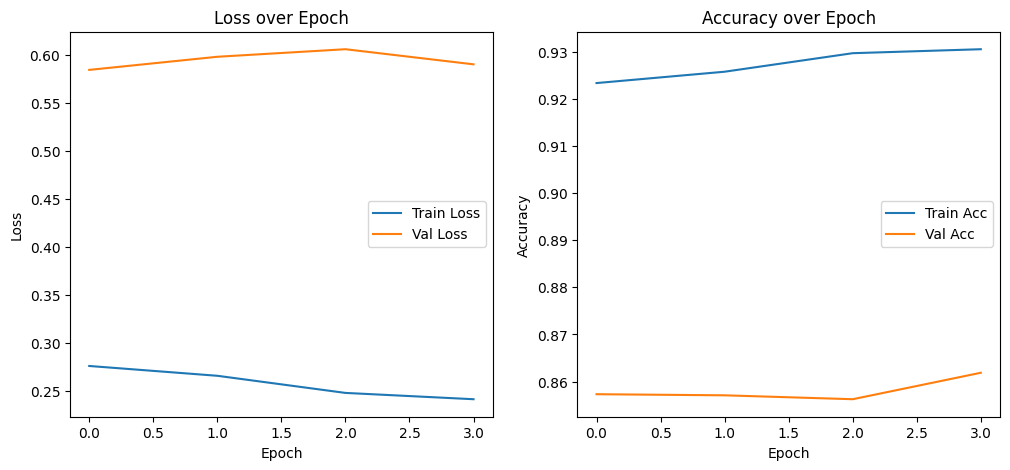

In [ ]:
#visualize result
plt.figure(figsize=(12,5))

#plot loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epoch")
plt.legend()

#plot accuracy
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epoch")
plt.legend()

plt.show()


In [ ]:
#save model
os.makedirs("/content/models", exist_ok=True)
model_path = "/content/models/best_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Mô hình đã được lưu tại: {model_path}")


Mô hình đã được lưu tại: /content/models/best_model.pth


In [ ]:
# custom dataset for test set
class BirdTestDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.df.loc[idx, "FILE"]
        full_path = os.path.join(self.img_dir, file_path)
        image = Image.open(full_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, file_path


In [ ]:
#inference on test set
test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = BirdTestDataset(
    csv_file="/content/dataset/test.csv",
    img_dir="/content/dataset/test",
    transform=test_transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load saved model
model.load_state_dict(torch.load(model_path))
model.eval()

all_preds = []
all_files = []

with torch.no_grad():
    for images, filepaths in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_files.extend(filepaths)


<ipython-input-74-9517e6a79c51>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [ ]:
#convert class id to label
train_df = pd.read_csv("/content/dataset/train.csv")
class_names = train_df.groupby("class id")["labels"].first().to_dict()

#check
print("Class mapping:", class_names)


Class mapping: {0.0: 'ABBOTTS BABBLER', 1.0: 'ABBOTTS BOOBY', 2.0: 'ABYSSINIAN GROUND HORNBILL', 3.0: 'AFRICAN CROWNED CRANE', 4.0: 'AFRICAN EMERALD CUCKOO', 5.0: 'AFRICAN FIREFINCH', 6.0: 'AFRICAN OYSTER CATCHER', 7.0: 'AFRICAN PIED HORNBILL', 8.0: 'AFRICAN PYGMY GOOSE', 9.0: 'ALBATROSS', 10.0: 'ALBERTS TOWHEE', 11.0: 'ALEXANDRINE PARAKEET', 12.0: 'ALPINE CHOUGH', 13.0: 'ALTAMIRA YELLOWTHROAT', 14.0: 'AMERICAN AVOCET', 15.0: 'AMERICAN BITTERN', 16.0: 'AMERICAN COOT', 17.0: 'AMERICAN FLAMINGO', 18.0: 'AMERICAN GOLDFINCH', 19.0: 'AMERICAN KESTREL', 20.0: 'AMERICAN PIPIT', 21.0: 'AMERICAN REDSTART', 22.0: 'AMERICAN ROBIN', 23.0: 'AMERICAN WIGEON', 24.0: 'AMETHYST WOODSTAR', 25.0: 'ANDEAN GOOSE', 26.0: 'ANDEAN LAPWING', 27.0: 'ANDEAN SISKIN', 28.0: 'ANHINGA', 29.0: 'ANIANIAU', 30.0: 'ANNAS HUMMINGBIRD', 31.0: 'ANTBIRD', 32.0: 'ANTILLEAN EUPHONIA', 33.0: 'APAPANE', 34.0: 'APOSTLEBIRD', 35.0: 'ARARIPE MANAKIN', 36.0: 'ASHY STORM PETREL', 37.0: 'ASHY THRUSHBIRD', 38.0: 'ASIAN CRESTED IBIS', 

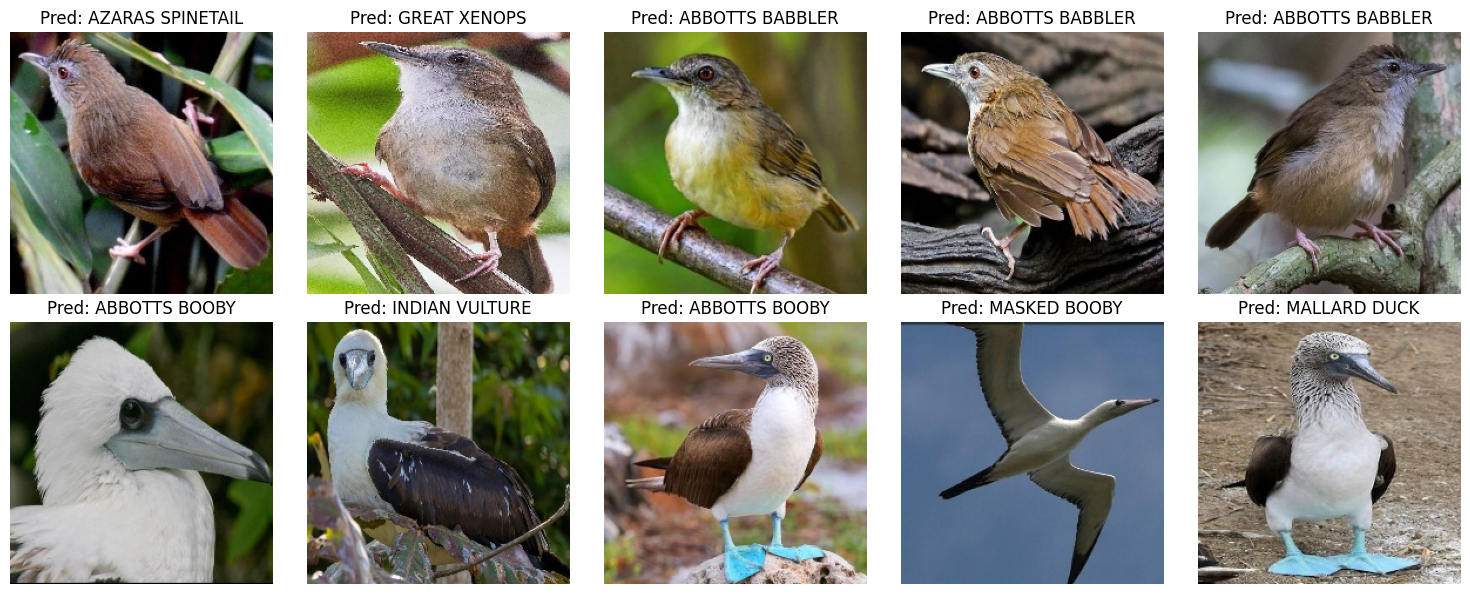

In [ ]:
#prediction
num_images = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

model.eval()
with torch.no_grad():
    for i in range(num_images):

        image_path = os.path.join("/content/dataset/test", test_dataset.df.loc[i, "FILE"])
        image = Image.open(image_path).convert("RGB")


        input_tensor = test_transform(image).unsqueeze(0).to(device)


        output = model(input_tensor)
        _, pred = torch.max(output, 1)

        predicted_class = class_names.get(pred.item(), f"Class {pred.item()}")

        ax = axes[i // 5, i % 5]
        ax.imshow(image)
        ax.set_title(f"Pred: {predicted_class}", fontsize=12)
        ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# create file for submission
submission = pd.DataFrame({
    "filepath": all_files,
    "predicted_class_id": all_preds
})
submission.to_csv("/content/dataset/submission.csv", index=False)
print("File submission.csv đã được tạo!")


File submission.csv đã được tạo!


In [ ]:
from google.colab import files
files.download("/content/dataset/submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>